# RCによるDouble Attractorの予測を行う

まず、ライブラリをインポートする。

In [101]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import reservoirpy as rpy

rpy.verbosity(0)

from reservoirpy.nodes import Reservoir, Ridge

from reservoirpy.observables import nrmse, rsquare

# just a little tweak to center the plots, nothing to worry about
from IPython.core.display import HTML
HTML("""
<style>
.img-center {
    display: block;
    margin-left: auto;
    margin-right: auto;
    }
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
    }
</style>
""")

rpy.set_seed(42)

Double Attractorモデルを数値シミュレーションする。

timestepは2500に設定する。

学習期間は1000ステップ。

テスト期間は1000ステップ。

その後500ステップ弱をGenerative Modelで予測する。

In [102]:
from reservoirpy.datasets import doublescroll

timesteps = 2510
x0 = [0.37926545, 0.058339, -0.08167691]
X = doublescroll(timesteps, x0=x0, method="RK23")

In [103]:
X.shape

(2510, 3)

In [104]:
X

array([[ 0.37926545,  0.058339  , -0.08167691],
       [ 0.44028269,  0.10021867, -0.05833454],
       [ 0.51313763,  0.13717996, -0.02643101],
       ...,
       [ 1.08020965,  0.26483236,  0.2231595 ],
       [ 1.17537863,  0.34121078,  0.2867887 ],
       [ 1.27039126,  0.41972612,  0.36629032]])

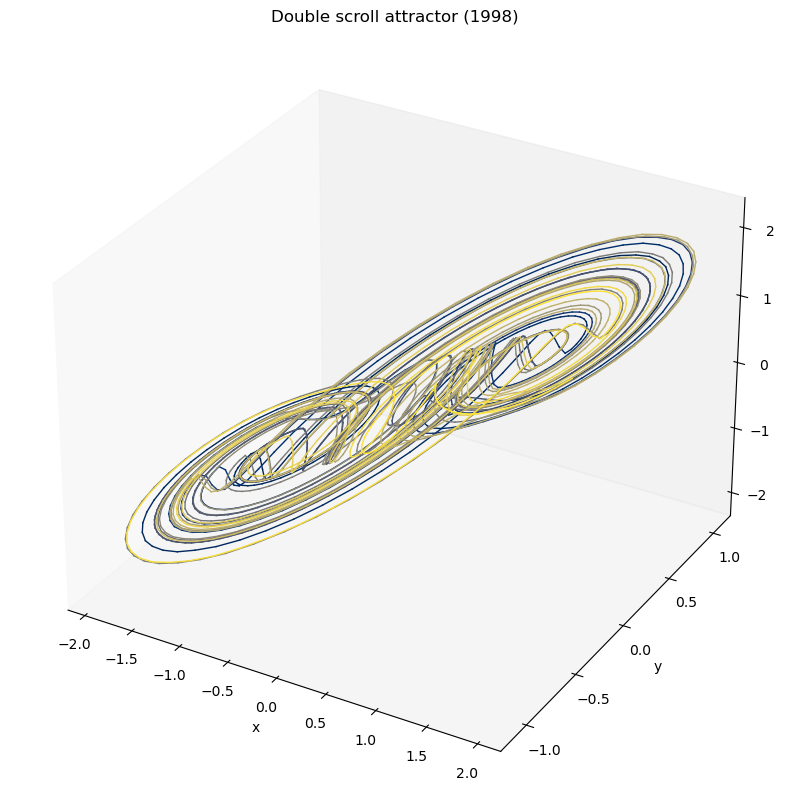

In [105]:
fig = plt.figure(figsize=(10, 10))
ax  = fig.add_subplot(111, projection='3d')
ax.set_title("Double scroll attractor (1998)")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.grid(False)

for i in range(timesteps-1):
    ax.plot(X[i:i+2, 0], X[i:i+2, 1], X[i:i+2, 2], color=plt.cm.cividis(255*i//timesteps), lw=1.0)

plt.show()

特に正規化等は行わない。
hyperoptを用いてhyperparameterの最適化を行う。

In [106]:
# Objective functions accepted by ReservoirPy must respect some conventions:
#  - dataset and config arguments are mandatory, like the empty '*' expression.
#  - all parameters that will be used during the search must be placed after the *.
#  - the function must return a dict with at least a 'loss' key containing the result
# of the loss function. You can add any additional metrics or information with other 
# keys in the dict. See hyperopt documentation for more informations.
def objective(dataset, config, *, iss, N, sr, lr, ridge, seed):
    
    # This step may vary depending on what you put inside 'dataset'
    train_data, validation_data = dataset
    X_train, y_train = train_data
    X_val, y_val = validation_data
    
    # You can access anything you put in the config 
    # file from the 'config' parameter.
    instances = config["instances_per_trial"]
    
    # The seed should be changed across the instances, 
    # to be sure there is no bias in the results 
    # due to initialization.
    variable_seed = seed 
    
    losses = []; r2s = [];
    for n in range(instances):
        # Build your model given the input parameters
        reservoir = Reservoir(N, 
                              sr=sr, 
                              lr=lr, 
                              input_scaling=iss, 
                              seed=variable_seed)
        
        readout = Ridge(ridge=ridge)

        model = reservoir >> readout


        # Train your model and test your model.
        predictions = model.fit(X_train, y_train) \
                           .run(X_test)
        
        loss = nrmse(y_test, predictions, norm_value=np.ptp(X_train))
        r2 = rsquare(y_test, predictions)
        
        # Change the seed between instances
        variable_seed += 1
        
        losses.append(loss)
        r2s.append(r2)

    # Return a dictionnary of metrics. The 'loss' key is mandatory when
    # using hyperopt.
    return {'loss': np.mean(losses),
            'r2': np.mean(r2s)}

In [107]:
hyperopt_config = {
    "exp": f"hyperopt-multiscroll", # the experimentation name
    "hp_max_evals": 200,             # the number of differents sets of parameters hyperopt has to try
    "hp_method": "random",           # the method used by hyperopt to chose those sets (see below)
    "seed": 42,                      # the random state seed, to ensure reproducibility
    "instances_per_trial": 3,        # how many random ESN will be tried with each sets of parameters
    "hp_space": {                    # what are the ranges of parameters explored
        "N": ["choice", 500],             # the number of neurons is fixed to 500
        "sr": ["loguniform", 1e-2, 10],   # the spectral radius is log-uniformly distributed between 1e-2 and 10
        "lr": ["loguniform", 1e-3, 1],  # idem with the leaking rate, from 1e-3 to 1
        "iss": ["choice", 0.9],           # the input scaling is fixed
        "ridge": ["choice", 1e-7],        # and so is the regularization parameter.
        "seed": ["choice", 1234]          # an other random seed for the ESN initialization
    }
}


import json

# we precautionously save the configuration in a JSON file
# each file will begin with a number corresponding to the current experimentation run number.
with open(f"{hyperopt_config['exp']}.config.json", "w+") as f:
    json.dump(hyperopt_config, f)

データを準備する。

学習期間は1000ステップ。
テスト期間は1000ステップ。

In [108]:
from reservoirpy.datasets import to_forecasting

train_len = 2000

x, y = to_forecasting(X, forecast=1)
X_train, y_train = x[:2000], y[:2000]
X_test, y_test = x[2000:], y[2000:]

dataset = ((X_train, y_train), (X_test, y_test))

hyperoptを走らせる。

In [109]:
from reservoirpy.hyper import research

best = research(objective, dataset, f"{hyperopt_config['exp']}.config.json", ".")

100%|██████████| 200/200 [03:08<00:00,  1.06trial/s, best loss: 0.00015230889303737558]


In [110]:
best

({'N': 0,
  'iss': 0,
  'lr': 0.8310012558635558,
  'ridge': 0,
  'seed': 0,
  'sr': 0.2237449778907503},
 <hyperopt.base.Trials at 0x14f4d9f10>)

In [111]:
type(best)

tuple

In [126]:
hyperparameters = {
    'N': 0,
    'iss': 0,
    'lr': 0.8310012558635558,
    'ridge': 0,
    'seed': 0,
    'sr': 0.2237449778907503
}

In [127]:
hyperparameters['N'] = 500
hyperparameters['iss'] = 0.9
hyperparameters['ridge'] = 1e-7
hyperparameters['seed'] = 1234
hyperparameters

{'N': 500,
 'iss': 0.9,
 'lr': 0.8310012558635558,
 'ridge': 1e-07,
 'seed': 1234,
 'sr': 0.2237449778907503}

In [128]:
def reset_esn():
    from reservoirpy.nodes import Reservoir, Ridge

    reservoir = Reservoir(N, 
                      sr=sr, 
                      lr=lr, 
                      input_scaling=iss, 
                      seed=seed)
    readout = Ridge(ridge=ridge)

    return reservoir >> readout

In [129]:
# bestから取得したハイパーパラメータを設定
N = 500
iss = 0.9
lr = 0.8310012558635558
ridge = 1e-7
seed = 1234
sr = 0.2237449778907503

# データセットからトレーニングとバリデーションデータを取得
train_data, validation_data = dataset
X_train, y_train = train_data
X_val, y_val = validation_data

# モデルの構築
reservoir = Reservoir(N, 
                      sr=sr, 
                      lr=lr, 
                      input_scaling=iss, 
                      seed=seed)
readout = Ridge(ridge=ridge)
model = reservoir >> readout

# モデルの訓練と予測
predictions = model.fit(X_train, y_train).run(X_val)

# 評価（lossとr2の計算方法は既存のものを使用しています）
loss = nrmse(y_val, predictions, norm_value=np.ptp(X_train))
r2 = rsquare(y_val, predictions)

print("Loss:", loss)
print("R^2:", r2)

Loss: 0.0001579050277040674
R^2: 0.999999322598545


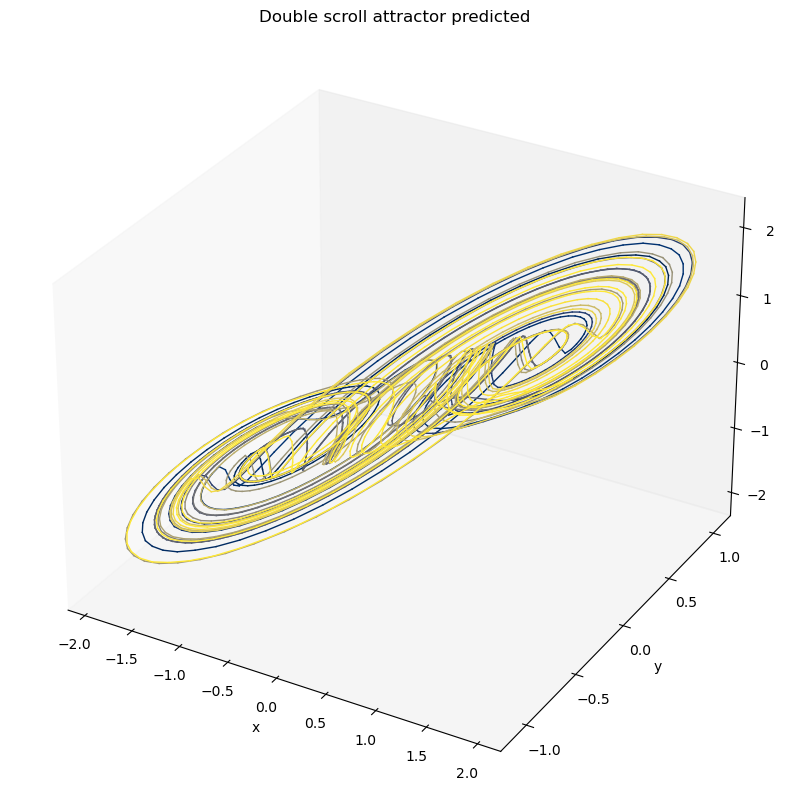

In [130]:
fig = plt.figure(figsize=(15, 10))
ax  = fig.add_subplot(111, projection='3d')
ax.set_title("Double scroll attractor predicted")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.grid(False)

for i in range(timesteps-1):
    ax.plot(X[i:i+2, 0], X[i:i+2, 1], X[i:i+2, 2], color=plt.cm.cividis(255*i//1999), lw=1.0)

plt.show()

ここまで、通常の1期先予測の方法を見た。

さて、ここから、ESNに自分の予測に基づいて、100期先までを予測してもらう。

# Generative Modelを使う。

In [131]:
seed_timesteps = 100

warming_inputs = X_test[:seed_timesteps]

warming_out = model.run(warming_inputs, reset=True)  # warmup

In [132]:
nb_generations = 400

X_gen = np.zeros((nb_generations, 3))
y = warming_out[-1]
for t in range(nb_generations):  # generation
    y = model(y)
    X_gen[t, :] = y

In [133]:
def plot_generation(X_gen, X_t, nb_generations, warming_out=None, warming_inputs=None, seed_timesteps=0):

    plt.figure(figsize=(15, 5))
    if warming_out is not None:
        plt.plot(np.vstack([warming_out, X_gen]), label="Generated timeseries")
    else:
        plt.plot(X_gen, label="Generated timeseries")

    plt.plot(np.arange(nb_generations)+seed_timesteps, X_t, linestyle="--", label="Real timeseries")

    if warming_inputs is not None:
        plt.plot(np.arange(seed_timesteps), warming_inputs, linestyle="--", label="Warmup")

    plt.plot(np.arange(nb_generations)+seed_timesteps, np.abs(X_t - X_gen),
             label="Absolute deviation")

    if seed_timesteps > 0:
        plt.fill_between([0, seed_timesteps], *plt.ylim(), facecolor='lightgray', alpha=0.5, label="Warmup")

    plt.plot([], [], ' ', label=f"$R^2 = {round(rsquare(X_t, X_gen), 4)}$")
    plt.plot([], [], ' ', label=f"$NRMSE = {round(nrmse(X_t, X_gen), 4)}$")
    plt.legend(
    )
    plt.show()

In [134]:
X_gen

array([[ 1.23290251,  0.34116425,  0.91249559],
       [ 1.2471604 ,  0.35201165,  0.95421575],
       [ 1.25722306,  0.35910948,  0.99623872],
       ...,
       [-1.16545462, -0.28116345, -0.81123078],
       [-1.18437032, -0.30022343, -0.8435374 ],
       [-1.20401362, -0.31394307, -0.87873922]])

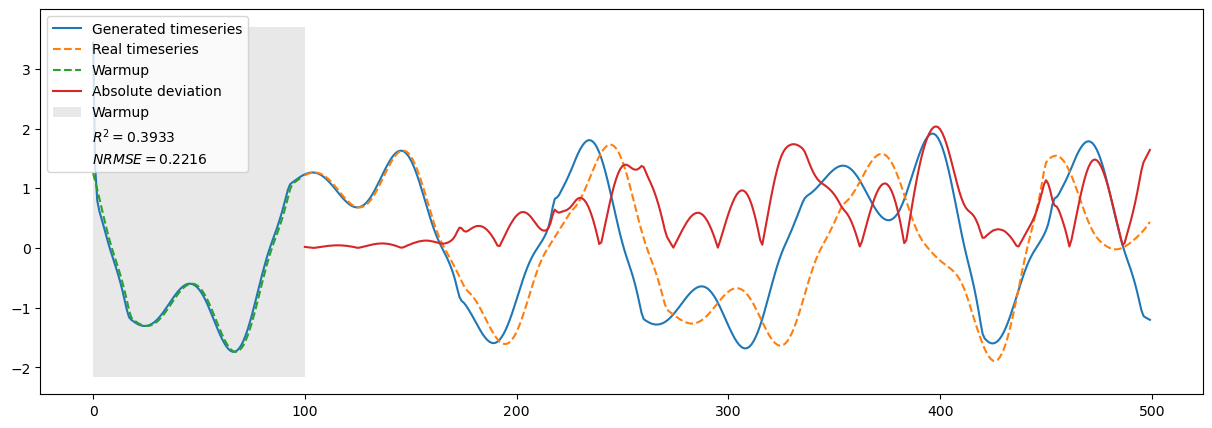

In [135]:
X_t_X = X_test[seed_timesteps: nb_generations+seed_timesteps][:, :1]

#Double Scroll AttractorのXを描画する
plot_generation(X_gen[:, :1], X_t_X, nb_generations, warming_out=warming_out[:, :1],
                warming_inputs=warming_inputs[:, :1], seed_timesteps=seed_timesteps)

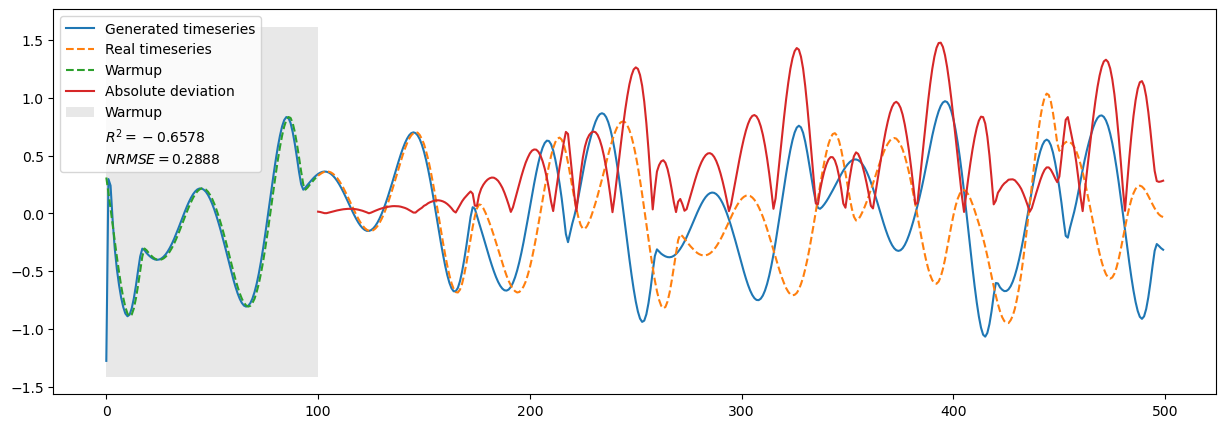

In [136]:
X_t_X = X_test[seed_timesteps: nb_generations+seed_timesteps][:, 1:2]

#Double Scroll AttractorのYを描画する
plot_generation(X_gen[:, 1:2], X_t_X, nb_generations, warming_out=warming_out[:, 1:2],
                warming_inputs=warming_inputs[:, 1:2], seed_timesteps=seed_timesteps)

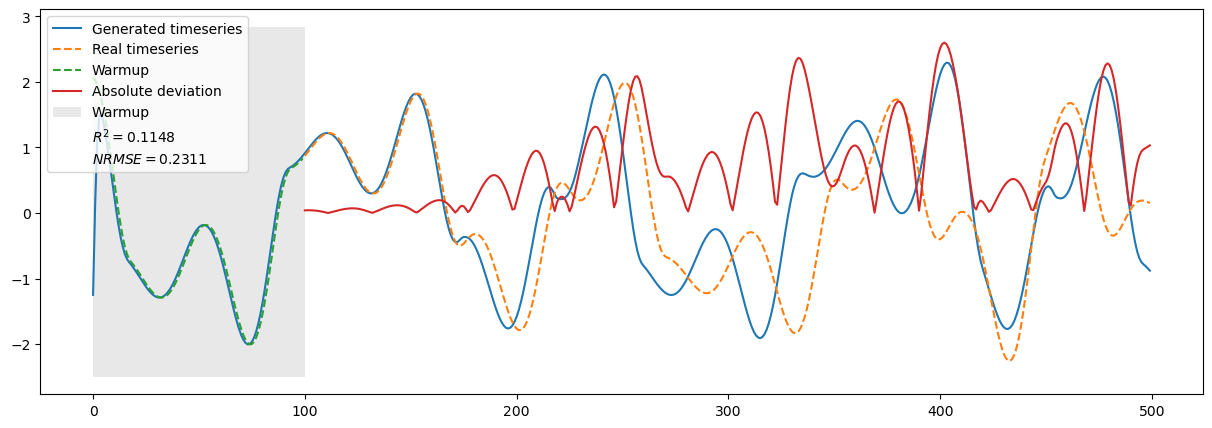

In [137]:
X_t_X = X_test[seed_timesteps: nb_generations+seed_timesteps][:, 2:3]

#Double Scroll AttractorのZを描画する
plot_generation(X_gen[:, 2:3], X_t_X, nb_generations, warming_out=warming_out[:, 2:3],
                warming_inputs=warming_inputs[:, 2:3], seed_timesteps=seed_timesteps)

Double Scroll Attractorの場合、X, Y, Z項全て100期先予測を始めたあたりからズレが大きくなることがわかる。